In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from gridbase_pathplanning import*
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class Dijkstra(GridBasePathPlanning):
    def __init__(
        self, world, grid_size_ratio=1,
        drawTakenPath_flag=True, drawCost_flag=False, cost_adj1=15.0, cost_adj2=2.0
    ):
        super().__init__(world, grid_size_ratio)
        
        self.grid_map = world.grid_map
        self.cost_map = np.full(self.grid_cost_num, 0, dtype=float)    #その地点が持つコスト
        self.id_map = np.full(self.grid_cost_num, 0, dtype=float)    #グリッドIDマップ
        self.parent_id_map = np.full(self.grid_cost_num, 0, dtype=float)    #親グリッドのID
        
        self.open_list = []
        self.closed_list = []
        self.resultPath = []
        self.takenPath = []
        
        self.drawTakenPath_flag = drawTakenPath_flag #経路描画のフラグ
        self.drawCost_flag = drawCost_flag
        self.drawedTakenPath_flag = False
        
        self.cost_adj1 = cost_adj1
        self.cost_adj2 = cost_adj2
        
        self.pp_algorithm_name = "Dijkstra"
        
        cnt = 0
        for u, grid in np.ndenumerate(self.cost_map):
            self.id_map[u[0]][u[1]] = cnt
            if self.hasStart(u):
                self.open_list.append([cnt, 0, 0])
            cnt += 1
                
    def draw(self, ax, elems):
        if not self.isClosed(self.indexWorldToCost(self.world.goal_index)): #ゴールにたどり着いていなければコストを計算
            index, cost = self.expandGrid()
            self.drawCost(index, cost, ax, elems, self.cost_adj1, self.cost_adj2) if self.drawCost_flag else None
        else:
            if self.drawTakenPath_flag is True and self.drawedTakenPath_flag is False:  #経路の描画
                self.getPath()    #経路の算出
                self.drawPath(ax, elems)    #経路の描画
                self.drawedTakenPath_flag = True
    
    def plot(self, figsize=(4, 4), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        for index in self.takenPath:
            if not self.hasStart(index) and not self.hasGoal(index):
                self.drawCostSizeGrid(index, "red", 0.5, ax)
        
        plt.show()

        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def run(self):
        self.currentIndex = self.indexWorldToCost(self.world.start_index)
        self.calculatePath()
        self.getPath()
        while not self.hasGoal(self.currentIndex):
            self.currentIndex = self.next(self.currentIndex)
            self.takenPath.append(self.currentIndex)
        
    def next(self, index):
        if len(self.resultPath) == 0:
            raise PathNotCalculatedError("Path are not calculated")
        if self.world.isGoal(index):
            return index
        else:
            if not np.any([np.all(index == path) for path in self.resultPath]):
                return None
            idx = np.where(np.all(self.resultPath==index, axis=1)==True)[0][0]
            if(idx == 0):
                next_index = self.indexWorldToCost(self.world.goal_index)
            else:
                next_index = self.resultPath[idx-1]
        return next_index
    
    def expandGrid(self):
        if len(self.open_list) == 0:
            raise PathNotFoundError("Path was not found")
        val = np.argmin(self.open_list, axis=0) #評価マップの中から最も小さいもの抽出
        grid_id, cost_f, cost_g = self.open_list[val[1]]
        index = np.array([np.where(self.id_map==grid_id)[0][0], np.where(self.id_map==grid_id)[1][0]])
        self.open_list.remove([grid_id, cost_f, cost_g])  #オープンリストから削除
        self.closed_list.append([grid_id, cost_f, cost_g])  #クローズドリストに追加
        self.calculateCost(index, cost_f, cost_g)    #コストの計算
        return index, cost_f
    
    def calculateCost(self, index, cost_f, cost_g):  #コストの計算
        for n in self.listFreeNeigbor(index):
            evaluation_f = cost_g + self.cost(n) + self.c(n, index)    #評価を計算
            if self.isOpened(n): #オープンリストに含まれているか
                its_index, its_cost_f, its_cost_g = self.open_list[[val[0] for val in self.open_list].index(self.id(n))]
                if its_cost_f > evaluation_f: #評価が更新されなければ繰り返しを戻す
                    self.open_list.remove([its_index, its_cost_f, its_cost_g])
                else:
                    continue
            elif self.isClosed(n): #クローズドリストに含まれているか
                its_index, its_cost_f, its_cost_g = self.closed_list[[val[0] for val in self.closed_list].index(self.id(n))]
                if its_cost_f > evaluation_f:
                    self.closed_list.remove([its_index, its_cost_f, its_cost_g])
                else:
                    continue
            self.parent_id_map[n[0]][n[1]] = self.id(index)
            self.open_list.append([self.id(n), evaluation_f, evaluation_f])
    
    def getPath(self):
        parent_id = self.b(self.indexWorldToCost(self.world.goal_index))
        while parent_id != self.id(self.indexWorldToCost(self.world.start_index)):
            parent = np.where(self.id_map==parent_id)
            self.resultPath.append(np.array([parent[0][0], parent[1][0]]))
            parent_id = self.b(parent)
        self.resultPath.append(self.indexWorldToCost(self.world.start_index))
    
    def calculatePath(self):
        while not self.isClosed(self.indexWorldToCost(self.world.goal_index)):
            _, _ = self.expandGrid()
    
    def listFreeNeigbor(self, index):
        neigbor_indice = []
        for neigbor_grid in neigbor_grids:
            neigbor_index = index + neigbor_grid
            if not self.isCostGridOutOfBounds(neigbor_index) and not self.hasObstacle(neigbor_index):
                neigbor_indice.append(neigbor_index)
        return neigbor_indice
    
    def isOpened(self, u):
        return self.id(u) in [val[0] for val in self.open_list]
    
    def isClosed(self, u):
        return self.id(u) in [val[0] for val in self.closed_list]
    
    def id(self, u):
        return self.id_map[u[0]][u[1]]
    
    def cost(self, u):
        return self.cost_map[u[0]][u[1]]
    
    def b(self, u):
        return self.parent_id_map[int(u[0])][int(u[1])]
    
    def c(self, u, v):
        return np.linalg.norm(u - v)
    
    def drawCost(self, index, cost_f, ax, elems, cost_adj1=15.0, cost_adj2=2.0):
        if not self.hasStart(index) and not self.hasGoal(index):
            c = "blue"
            fill = False
            alpha = 1.0
            
            c_num = int(cost_adj1 * (cost_f - cost_adj2)) #Black→Blue
            if c_num > 0xff: #Blue → Cyan
                c_num = (c_num-0xff)*16*16 + 0xff
                if c_num > 0xffff: #Cyan → Green
                    c_num = 0xffff - int((c_num-0x100ff)/256)*2
                    if c_num < 0xff00: #Green → Yellow
                        c_num = (0xff00-c_num)*65536+0xff00
                        if c_num > 0xffff00: #Yellow → Red
                            c_num = 0xffff00 - int((c_num-0xffff00)/65536)*256
            c = '#' + format(int(c_num), 'x').zfill(6)
            alpha=0.5
            self.drawCostSizeGrid(index, c, alpha, ax)
    
    def drawPath(self, ax, elems=None):
        for grid in self.resultPath:
            if not self.hasStart(grid) and not self.hasGoal(grid):
                self.drawCostSizeGrid(grid, "red", 0.5, ax, elems)

<IPython.core.display.Javascript object>


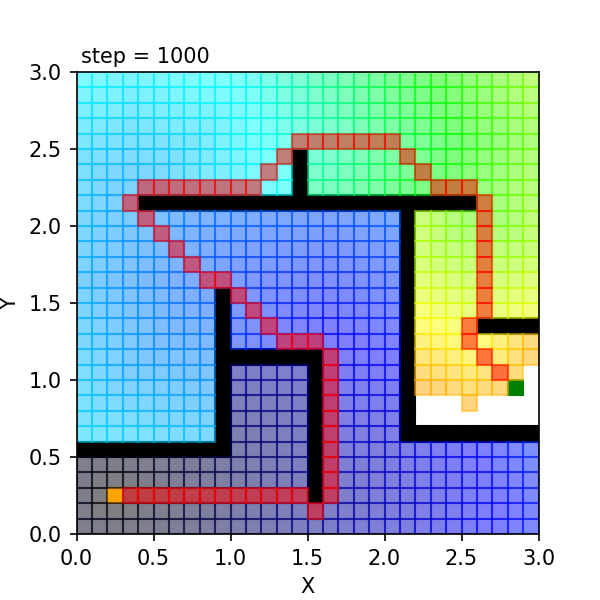

In [3]:
if __name__ == "__main__":
    time_span = 10
    time_interval = 0.01

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])

    map_data = "../csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)

    #cost_adj1, cost_adj2 = 15.0, 2.0    #map1
    cost_adj1, cost_adj2 = 10.0, 0.0    #map2
    #cost_adj1, cost_adj2 = 3.2, 2.0    #map3
    world.append(Dijkstra(world, grid_size_ratio=1, drawTakenPath_flag=True, drawCost_flag=True, cost_adj1=cost_adj1, cost_adj2=cost_adj2))

    world.draw()
    #world.ani.save('dijkstra_map1.gif', writer='pillow', fps=100)    #アニメーション保存